In [1]:
#import qiskit tools
import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile, Aer, IBMQ
from qiskit.tools.visualization import circuit_drawer
from qiskit.tools.monitor import job_monitor, backend_monitor, backend_overview
from qiskit.providers.aer import noise

#import python stuff
import matplotlib.pyplot as plt
import numpy as np
import time


In [2]:
# Set devices, if using a real device
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
quito = provider.get_backend('ibmq_quito')


In [3]:
sim = Aer.get_backend('aer_simulator')


In [4]:
def make_chsh_circuit(theta_vec):
    """Return a list of QuantumCircuits for use in a CHSH experiemnt
    (one for each value of theta in theta_vec)
    
        Args:
            theta_vec (list): list of values of angles between the bases of Alice and Bob
        
        Returns:
            List[QuantumCircuit]: CHSH QuantumCircuits for each value of theta
    """
    chsh_circuits = []
    
    for theta in theta_vec:
        obs_vec = ['00', '01', '10', '11']
        for el in obs_vec:
            qc = QuantumCircuit(2,2)
            qc.h(0)
            qc.cx(0, 1)
            qc.ry(theta, 0)
            for a in range(2):
                if el[a] == '1':
                    qc.h(a) 
            qc.measure(range(2),range(2))
            chsh_circuits.append(qc)

    return chsh_circuits  


In [5]:
def compute_chsh_witness(counts):
    """Computes expectation values for the CHSH inequality, for each
    angle (theta) between measurement axis.

        Args: counts (list[dict]): dict of counts for each experiment
              (4 per value of theta)

        Returns:
            Tuple(List, List): Tuple of lists with the two CHSH witnesses
    """
    # Order is ZZ,ZX,XZ,XX
    
    CHSH1 = []
    CHSH2 = []
    # Divide the list of dictionaries in sets of 4
    for i in range(0, len(counts), 4):  
        theta_dict = counts[i:i + 4]
        zz = theta_dict[0]
        zx = theta_dict[1]
        xz = theta_dict[2]
        xx = theta_dict[3]

        no_shots = sum(xx[y] for y in xx)

        chsh1 = 0
        chsh2 = 0

        for element in zz:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1+= parity*zz[element]
            chsh2+= parity*zz[element]

        for element in zx:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1+= parity*zx[element]
            chsh2-= parity*zx[element]

        for element in xz:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1-= parity*xz[element]
            chsh2+= parity*xz[element]

        for element in xx:
            parity = (-1)**(int(element[0])+int(element[1]))
            chsh1+= parity*xx[element]
            chsh2+= parity*xx[element]

        CHSH1.append(chsh1/no_shots)
        CHSH2.append(chsh2/no_shots)
    
    return CHSH1, CHSH2


In [6]:
number_of_thetas = 15
theta_vec = np.linspace(0,2*np.pi,number_of_thetas)
print(theta_vec)
print(2*np.pi*2/14)
print()
my_chsh_circuits = make_chsh_circuit(theta_vec)


[0.         0.44879895 0.8975979  1.34639685 1.7951958  2.24399475
 2.6927937  3.14159265 3.5903916  4.03919055 4.48798951 4.93678846
 5.38558741 5.83438636 6.28318531]
0.8975979010256552



In [7]:
my_chsh_circuits[8].draw()


┌───┐     ┌──────────┐┌─┐
q_0: ┤ H ├──■──┤ Ry(2π/7) ├┤M├
     └───┘┌─┴─┐└───┬─┬────┘└╥┘
q_1: ─────┤ X ├────┤M├──────╫─
          └───┘    └╥┘      ║ 
c: 2/═══════════════╩═══════╩═
                    1       0

In [8]:
my_chsh_circuits[9].draw()

┌───┐     ┌──────────┐┌─┐   
q_0: ┤ H ├──■──┤ Ry(2π/7) ├┤M├───
     └───┘┌─┴─┐└──┬───┬───┘└╥┘┌─┐
q_1: ─────┤ X ├───┤ H ├─────╫─┤M├
          └───┘   └───┘     ║ └╥┘
c: 2/═══════════════════════╩══╩═
                            0  1

In [9]:
my_chsh_circuits[10].draw()

┌───┐     ┌──────────┐┌───┐┌─┐
q_0: ┤ H ├──■──┤ Ry(2π/7) ├┤ H ├┤M├
     └───┘┌─┴─┐└───┬─┬────┘└───┘└╥┘
q_1: ─────┤ X ├────┤M├───────────╫─
          └───┘    └╥┘           ║ 
c: 2/═══════════════╩════════════╩═
                    1            0

In [10]:
my_chsh_circuits[11].draw()

┌───┐     ┌──────────┐┌───┐┌─┐
q_0: ┤ H ├──■──┤ Ry(2π/7) ├┤ H ├┤M├
     └───┘┌─┴─┐└──┬───┬───┘└┬─┬┘└╥┘
q_1: ─────┤ X ├───┤ H ├─────┤M├──╫─
          └───┘   └───┘     └╥┘  ║ 
c: 2/════════════════════════╩═══╩═
                             1   0

In [16]:
print((2*np.pi/7)*360/(2*np.pi))

51.42857142857143


In [11]:
# Execute and get counts
result_ideal = sim.run(my_chsh_circuits).result()

# tic = time.time()
# transpiled_circuits = transpile(my_chsh_circuits, quito)
# job_real = quito.run(transpiled_circuits, shots=8192)
# job_monitor(job_real)
# result_real = job_real.result()
# toc = time.time()

# print(toc-tic)


In [12]:
CHSH1_ideal, CHSH2_ideal = compute_chsh_witness(result_ideal.get_counts())
# CHSH1_real, CHSH2_real = compute_chsh_witness(result_real.get_counts())

# print(result_ideal.get_counts())
counts = result_ideal.get_counts()
for i in range(0, len(counts), 4):  
    print(counts[i:i + 4])
    theta_dict = counts[i:i + 4]
    zz = theta_dict[0]
    zx = theta_dict[1]
    xz = theta_dict[2]
    xx = theta_dict[3]
    print(zz)
    
    no_shots = sum(xx[y] for y in xx)

    chsh1 = 0
    chsh2 = 0

    for element in zz:
        print(element)
        print(element[0])
        parity = (-1)**(int(element[0])+int(element[1]))
        chsh1+= parity*zz[element]
        chsh2+= parity*zz[element]

    for element in zx:
        parity = (-1)**(int(element[0])+int(element[1]))
        chsh1+= parity*zx[element]
        chsh2-= parity*zx[element]

    for element in xz:
        parity = (-1)**(int(element[0])+int(element[1]))
        chsh1-= parity*xz[element]
        chsh2+= parity*xz[element]

    for element in xx:
        parity = (-1)**(int(element[0])+int(element[1]))
        chsh1+= parity*xx[element]
        chsh2+= parity*xx[element]


[{'11': 502, '00': 522}, {'01': 242, '11': 261, '10': 270, '00': 251}, {'11': 240, '01': 278, '00': 261, '10': 245}, {'00': 492, '11': 532}]
{'11': 502, '00': 522}
11
1
00
0
[{'01': 15, '10': 25, '00': 454, '11': 530}, {'01': 377, '11': 133, '10': 385, '00': 129}, {'01': 148, '11': 371, '10': 135, '00': 370}, {'01': 29, '11': 499, '10': 28, '00': 468}]
{'01': 15, '10': 25, '00': 454, '11': 530}
01
0
10
1
00
0
11
1
[{'01': 94, '10': 107, '00': 417, '11': 406}, {'11': 60, '01': 476, '00': 46, '10': 442}, {'00': 453, '10': 45, '11': 469, '01': 57}, {'11': 388, '10': 96, '00': 440, '01': 100}]
{'01': 94, '10': 107, '00': 417, '11': 406}
01
0
10
1
00
0
11
1
[{'11': 320, '10': 213, '00': 288, '01': 203}, {'11': 11, '01': 510, '00': 4, '10': 499}, {'01': 10, '10': 8, '00': 508, '11': 498}, {'11': 309, '01': 203, '00': 304, '10': 208}]
{'11': 320, '10': 213, '00': 288, '01': 203}
11
1
10
1
00
0
01
0
[{'11': 204, '01': 313, '00': 180, '10': 327}, {'11': 3, '00': 5, '10': 522, '01': 494}, {'01':

NameError: name 'CHSH1_real' is not defined

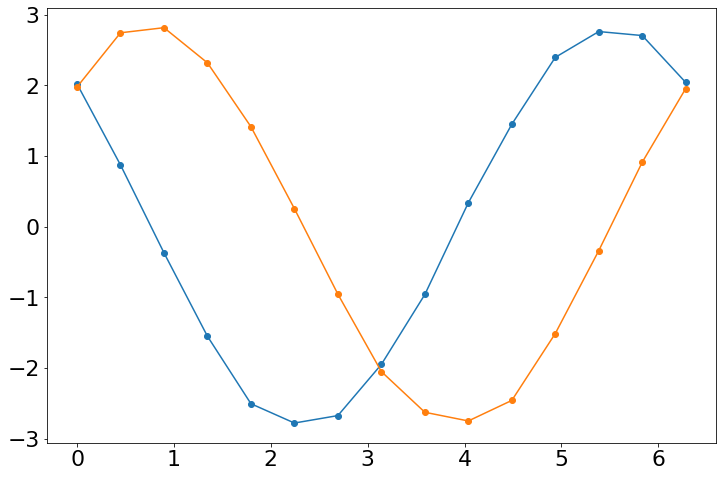

In [13]:
plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 22})
plt.plot(theta_vec,CHSH1_ideal,'o-',label = 'CHSH1 Noiseless')
plt.plot(theta_vec,CHSH2_ideal,'o-',label = 'CHSH2 Noiseless')

plt.plot(theta_vec,CHSH1_real,'x-',label = 'CHSH1 Quito')
plt.plot(theta_vec,CHSH2_real,'x-',label = 'CHSH2 Quito')

plt.grid(which='major',axis='both')
plt.rcParams.update({'font.size': 16})
plt.legend()
plt.axhline(y=2, color='r', linestyle='-')
plt.axhline(y=-2, color='r', linestyle='-')
plt.axhline(y=np.sqrt(2)*2, color='k', linestyle='-.')
plt.axhline(y=-np.sqrt(2)*2, color='k', linestyle='-.')
plt.xlabel('Theta')
plt.ylabel('CHSH witness')
